# Ultrasound breast imaging with Forge

In this notebook we solve the forward problem, generating true synthetic ultrasound for the 2D Anastasio breast model. 

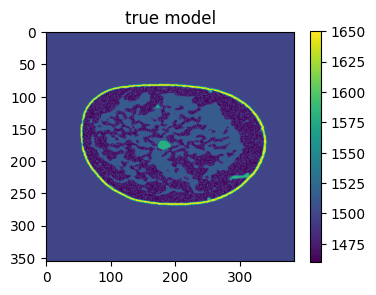

In [1]:
import numpy as np

# load the 2D anastasio breast model and set a water starting model
m = np.load('./data/anastasio2D.npy')
m0 = np.empty_like(m)
m0[:, :] = 1500
dx = 5e-4

import matplotlib.pyplot as plt

# plot the true model
plt.figure(figsize=(4,3))
plt.imshow(m)
plt.title('true model')
plt.colorbar()
plt.show()

In [2]:
# load the transducer geometry
r_geometry = np.load('./data/geometry.npy')
s_geometry = r_geometry.copy()

In [3]:
frequency = 5e5
gridpoints_per_wavelength = 6

min_wavelength = min(m.min(), m0.min())/frequency
dxi = min_wavelength/gridpoints_per_wavelength

In [4]:
r_posi = r_geometry/dxi
s_posi = s_geometry/dxi

In [5]:
from forge.utils import resample

# interpolate models to required grid-spacing dxi
mi = resample(m, dx, dxi)
m0i = resample(m0, dx, dxi)

In [6]:
# set the temporal increment, dt, to be small enough to meet the CFL condition for numerical stability
courant = 0.61
dt = (courant*dxi)/max(mi.max(), m0i.max())

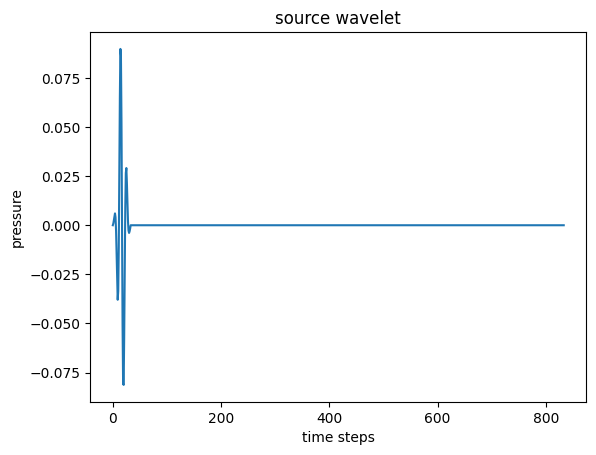

In [7]:
from forge.utils import tone_burst

time = 0.00015

# define the source wavelet 
source = tone_burst(dt, centre_freq=frequency, n_cycles=3, n_samples=round(time/dt), amplitude=1e-1, plot=True)

In [8]:
from forge.model import FullWaveformInversion

# instantiate a Forge WaveformInversion_2d class
true_model = FullWaveformInversion(model = mi, # true model
                           dx = dxi, # spatial increment
                           dt = dt, # temporal increment
                           r_pos = r_posi, # receiver positions
                           sampling_rate=len(source))

# forward modelling 
true_model.forward(s_posi, source)

device = cuda:0


forward modelling: 100%|██████████████████████| 834/834 [01:08<00:00, 12.16it/s]


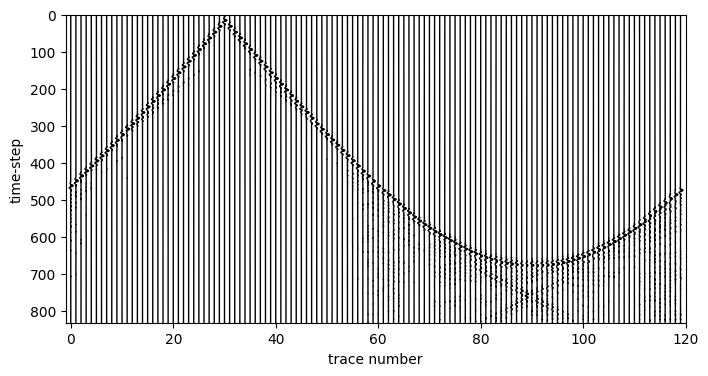

In [10]:
# save the true modelled data
np.save('./data/d.npy', true_model.d.numpy())

from forge.utils import trace_plot, trace_normalize

# visualize traces of true modelled data
trace_plot(trace_normalize(true_model.d), 30)